## Reinforcement Learning Chess
Reinforcement Learning Chess is a series of notebooks where I implement Reinforcement Learning algorithms to develop a chess AI. I start of with simpler versions (environments) that can be tackled with simple methods and gradually expand on those concepts untill I have a full-flegded chess AI.

[Notebook 1: Policy Iteration](https://www.kaggle.com/arjanso/reinforcement-learning-chess-1-policy-iteration)  
[Notebook 2: Model-free learning](https://www.kaggle.com/arjanso/reinforcement-learning-chess-2-model-free-methods)  
[Notebook 4: Policy Gradients](https://www.kaggle.com/arjanso/reinforcement-learning-chess-4-policy-gradients)

### Notebook III: Q-networks
In this notebook I implement an simplified version of chess named capture chess. In this environment the agent (playing white) is rewarded for capturing pieces (not for checkmate).  After running this notebook, you end up with an agent that can capture pieces against a random oponnent as demonstrated in the gif below. The main difference between this notebook and the previous one is that I use Q-networks as an alternative to Q-tables. Q-tables are nice and straightforward, but can only contain a limited amount of action values. Chess has state space complexity of 10<sup>47</sup>. Needless to say, this is too much information to put in a Q-table. This is where supervised learning comes in. A Q-network can represent a generalized mapping from state to action values.

![](https://images.chesscomfiles.com/uploads/game-gifs/90px/green/neo/0/cc/0/0/aXFZUWpyN1Brc1BPbHQwS211WEhudkh6cXohMGFPMExPUTJNUTY4MDY1OTI1NFpSND8yOT85M1Y5MTA3MUxLQ3RDUkpDSjcwTE0wN293V0d6Rzc2cHhWTXJ6NlhzQVg0dUM0WGNNWDU,.gif)



#### Import and Install

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import inspect

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install python-chess  # Python-Chess is the Python Chess Package that handles the chess environment
!pip install --upgrade git+https://github.com/arjangroen/RLC.git  # RLC is the Reinforcement Learning package

     |████████████████████████████████| 133kB 3.4MB/s 
  Cloning https://github.com/arjangroen/RLC.git to /tmp/pip-req-build-wsbm6wem
  Running command git clone -q https://github.com/arjangroen/RLC.git /tmp/pip-req-build-wsbm6wem
  Stored in directory: /tmp/pip-ephem-wheel-cache-2_uuic69/wheels/04/68/a5/cb835cd3d76a49de696a942739c71a56bfe66d0d8ea7b4b446
Successfully built RLC


In [4]:
import chess
from chess.pgn import Game
import RLC
from RLC.capture_chess.environment import Board
from RLC.capture_chess.learn import Q_learning
from RLC.capture_chess.agent import Agent

Using TensorFlow backend.


### The environment: Capture Chess
In this notebook we'll upgrade our environment to one that behaves more like real chess. It is mostly based on the Board object from python-chess.
Some modifications are made to make it easier for the algorithm to converge:
* There is a maximum of 25 moves, after that the environment resets
* Our Agent only plays white
* The Black player is part of the environment and returns random moves
* The reward structure is not based on winning/losing/drawing but on capturing black pieces:
    - pawn capture: +1
    - knight capture: +3
    - bishop capture: +3
    - rook capture: +5
    - queen capture: +9
* Our state is represent by an 8x8x8 array
    - Plane 0 represents pawns
    - Plane 1 represents rooks
    - Plane 2 represents knights
    - Plane 3 represents bishops
    - Plane 4 represents queens
    - Plane 5 represents kings
    - Plane 6 represents 1/fullmove number (needed for markov property)
    - Plane 7 represents can-claim-draw
* White pieces have the value 1, black pieces are minus 1
       


#### Board representation of python-chess:

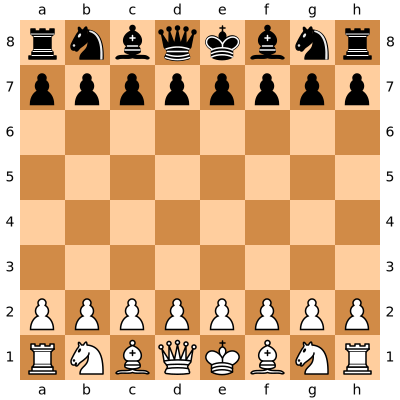

In [5]:
board = Board()
board.board

#### Numerical representation of the pawns (layer 0)
Change the index of the first dimension to see the other pieces

In [6]:
board.layer_board[0,::-1,:].astype(int)

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

### The Agent
* The agent is no longer a single piece, it's a chess player
* Its action space consist of 64x64=4096 actions:
    * There are 8x8 = 64 piece from where a piece can be picked up
    * And another 64 pieces from where a piece can be dropped. 
* Of course, only certain actions are legal. Which actions are legal in a certain state is part of the environment (in RL, anything outside the control of the agent is considered part of the environment). We can use the python-chess package to select legal moves. (It seems that AlphaZero uses a similar approach https://ai.stackexchange.com/questions/7979/why-does-the-policy-network-in-alphazero-work)

#### Implementation

In [7]:
board = Board()
agent = Agent(network='conv',gamma=0.1,lr=0.07)
R = Q_learning(agent,board)
R.agent.fix_model()
R.agent.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board_layer (InputLayer)        (None, 8, 8, 8)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 8, 8)      9           board_layer[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 8, 8)      9           board_layer[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 64)        0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_2 

In [8]:
print(inspect.getsource(agent.network_update))

    def network_update(self, minibatch):
        """
        Update the Q-network using samples from the minibatch
        Args:
            minibatch: list
                The minibatch contains the states, moves, rewards and new states.

        Returns:
            td_errors: np.array
                array of temporal difference errors

        """

        # Prepare separate lists
        states, moves, rewards, new_states = [], [], [], []
        td_errors = []
        episode_ends = []
        for sample in minibatch:
            states.append(sample[0])
            moves.append(sample[1])
            rewards.append(sample[2])
            new_states.append(sample[3])

            # Episode end detection
            if np.array_equal(sample[3], sample[3] * 0):
                episode_ends.append(0)
            else:
                episode_ends.append(1)

        # The Q target
        q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(
            self.fi

#### Q learning with a Q-network
**Theory**
- The Q-network is usually either a linear regression or a (deep) neural network. 
- The input of the network is the state (S) and the output is the predicted action value of each Action (in our case, 4096 values). 
- The idea is similar to learning with Q-tables. We update our Q value in the direction of the discounted reward + the max successor state action value
- I used prioritized experience replay to de-correlate the updates. If you want to now more about it, check the link in the references
> - I used fixed-Q targets to stabilize the learning process. 

#### Implementation
- I built two networks, A linear one and a convolutional one
- The linear model maps the state (8,8,8) to the actions (64,64), resulting in over 32k trainable weights! This is highly inefficient because there is no parameter sharing, but it will work.
- The convolutional model uses 2 1x1 convulutions and takes the outer product of the resulting arrays. This results in only 18 trainable weights! 
    - Advantage: More parameter sharing -> faster convergence
    - Disadvantage: Information gets lost -> lower performance
- For a real chess AI we need bigger neural networks. But now the neural network only has to learn to capture valuable pieces.

In [9]:
print(inspect.getsource(R.play_game))

    def play_game(self, k, greedy=False, maxiter=25):
        """
        Play a game of capture chess
        Args:
            k: int
                game count, determines epsilon (exploration rate)
            greedy: Boolean
                if greedy, no exploration is done
            maxiter: int
                Maximum amount of steps per game

        Returns:

        """
        episode_end = False
        turncount = 0

        # Here we determine the exploration rate. k is divided by 250 to slow down the exploration rate decay.
        eps = max(0.05, 1 / (1 + (k / 250))) if not greedy else 0.

        # Play a game of chess
        while not episode_end:
            state = self.env.layer_board
            explore = np.random.uniform(0, 1) < eps  # determine whether to explore
            if explore:
                move = self.env.get_random_action()
                move_from = move.from_square
                move_to = move.to_square
            else:
                ac

#### Demo

iter 0
iter 10
iter 20
iter 30
iter 40
iter 50
iter 60
iter 70
iter 80
iter 90
iter 100
iter 110
iter 120
iter 130
iter 140
iter 150
iter 160
iter 170
iter 180
iter 190
iter 200
iter 210
iter 220
iter 230
iter 240
iter 250
iter 260
iter 270
iter 280
iter 290
iter 300
iter 310
iter 320
iter 330
iter 340
iter 350
iter 360
iter 370
iter 380
iter 390
iter 400
iter 410
iter 420
iter 430
iter 440
iter 450
iter 460
iter 470
iter 480
iter 490
iter 500
iter 510
iter 520
iter 530
iter 540
iter 550
iter 560
iter 570
iter 580
iter 590
iter 600
iter 610
iter 620
iter 630
iter 640
iter 650
iter 660
iter 670
iter 680
iter 690
iter 700
iter 710
iter 720
iter 730
iter 740


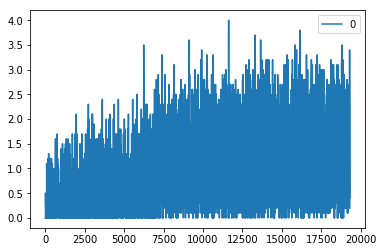

In [10]:
pgn = R.learn(iters=750)

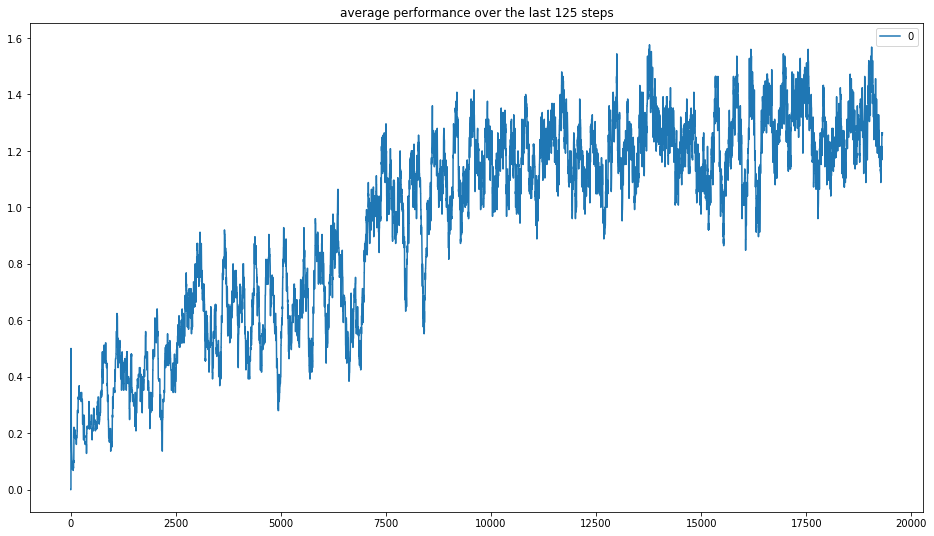

In [11]:
reward_smooth = pd.DataFrame(R.reward_trace)
reward_smooth.rolling(window=125,min_periods=0).mean().plot(figsize=(16,9),title='average performance over the last 125 steps')

The PGN file is exported to the output folder. You can analyse is by pasting it on the [chess.com analysis board](https://www.chess.com/analysis)

In [12]:
with open("final_game.pgn","w") as log:
    log.write(str(pgn))

## Learned action values analysis
So what has the network learned? The code below checks the action values of capturing every black piece for every white piece. 
- We expect that the action values for capturing black pieces is similar to the (Reinfeld) rewards we put in our environment. 
- Of course the action values also depend on the risk of re-capture by black and the opportunity for consecutive capture. 

In [13]:
board.reset()
bl = board.layer_board
bl[6,:,:] = 1/10  # Assume we are in move 10
av = R.agent.get_action_values(np.expand_dims(bl,axis=0))

av = av.reshape((64,64))

p = board.board.piece_at(20)#.symbol()


white_pieces = ['P','N','B','R','Q','K']
black_piece = ['_','p','n','b','r','q','k']

df = pd.DataFrame(np.zeros((6,7)))

df.index = white_pieces
df.columns = black_piece

for from_square in range(16):
    for to_square in range(30,64):
        from_piece = board.board.piece_at(from_square).symbol()
        to_piece = board.board.piece_at(to_square)
        if to_piece:
            to_piece = to_piece.symbol()
        else:
            to_piece = '_'
        df.loc[from_piece,to_piece] = av[from_square,to_square]
        
        

* ### Learned action values for capturing black (lower case) with white (upper case) pieces.
Underscore represents capturing an empty square

In [14]:
df[['_','p','n','b','r','q']]

,_,p,n,b,r,q
P,0.896254,1.711901,3.692928,4.038760,6.876412,10.946907
N,0.742323,1.417884,3.058672,3.345108,5.695396,9.066788
B,0.748629,1.429929,3.084656,3.373525,5.743780,9.143813
R,0.719952,1.375154,2.966494,3.244298,5.523756,8.793546
Q,0.702950,1.342680,2.896441,3.167684,5.393314,8.585888
K,0.670431,1.280565,2.762446,3.021141,5.143809,8.188688


## References
Reinforcement Learning: An Introduction  
> Richard S. Sutton and Andrew G. Barto  
> 1st Edition  
> MIT Press, march 1998  

RL Course by David Silver: Lecture playlist  
> https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ  

Experience Replay  
> https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits